## **Guns Detection**





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import necessary libraries



In [73]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

Function will read an image and convert to a specified version and resize depending on which algorithm is being used - in our case we using incepotion V3.

In [74]:
def get_image_value(path, dim): 
    img = image.load_img(path, target_size = dim)
    img = image.img_to_array(img)
    return img / 255

Function will take a list of image paths and returns the np array corresponding to each image. It also takes the dim and whether edge is specified in order to pass it to another function to apply these parameters. Uses get_image_value to perform these operations

In [75]:
def get_image_array(img_paths, dim): 
    final_array = []
    from tqdm import tqdm
    for path in tqdm(img_paths):
        img = get_image_value(path, dim)
        final_array.append(img)
    final_array = np.array(final_array)  
    return final_array

Function will create train and test split

In [76]:
def split_train_test():
    dim = (224, 224) 
    np.random.seed(10)  

    gun_paths = [f'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/gun/{i}' for i in os.listdir('/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/gun')] 
    gun_labels = [1 for i in range(len(gun_paths))]
    no_gun_paths = [f'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/no_gun/{i}' for i in os.listdir('/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/no_gun')]
    no_gun_labels = [0 for i in range(len(no_gun_paths))]
    
    np.random.shuffle(gun_paths)
    np.random.shuffle(no_gun_paths)

    paths = gun_paths + no_gun_paths
    labels = gun_labels + no_gun_labels

    x_train, x_test, y_train, y_test = train_test_split(paths, labels, stratify = labels, train_size = .75, random_state = 10)

    new_x_train = get_image_array(x_train, dim)
    new_x_test = get_image_array(x_test, dim)
    
    print('\nTrain Value Counts')
    print(pd.Series(y_train).value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Test Value Counts')
    print(pd.Series(y_test).value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('X Train Shape')
    print(new_x_train.shape)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('X Test Shape')
    print(new_x_test.shape)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)
    train_test = (new_x_train, new_x_test, y_train, y_test)
    return train_test

x_train, x_test, y_train, y_test = split_train_test()

100%|██████████| 154/154 [00:00<00:00, 486.63it/s]


Train Value Counts
1    250
0    211
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    83
0    71
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(461, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(154, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Show random image from train dataset

label 1 -> gun


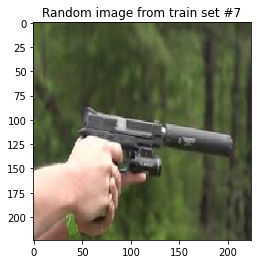

In [77]:
random_img = np.random.randint(len(x_train))
plt.imshow(x_train[random_img].reshape(224,224,3))
plt.title(f'Random image from train set #{random_img}')

gun = 'label 1 -> gun'
no_gun = 'label 0 -> no gun'
if y_train[random_img][0] == 0:
  print(gun)
else:
  print(no_gun)

Function will create the model - InceptionV3 with the trained weights

## InceptionV3

In [78]:
def get_inceptionv3(dim):
    model = Sequential()
    base_model = InceptionV3(weights = 'imagenet', include_top = False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    predictions = Dense(2, activation = 'softmax')(x)
    
    model = Model(inputs = base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy') 
    return model

Prevents overfitting and saves models every time the validation loss improves in file 'ModelWeight.h5'

In [79]:
early_stopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 10, min_delta = 0.00075)
model_checkpoint = ModelCheckpoint(r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights.h5', verbose = 1, save_best_only = True, monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 50
batch_size = 32
model = get_inceptionv3(dim = (224,224, 3)) 

Training the model

In [80]:
fit = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                callbacks = [early_stopping, model_checkpoint, lr_plat],
                validation_data = (x_test, y_test), verbose= 1)

Epoch 1/50
15/15 [==============================] - 6s 173ms/step - loss: 1.3952 - val_loss: 0.0753

Epoch 00001: val_loss improved from inf to 0.07535, saving model to /content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights.h5
Epoch 2/50
15/15 [==============================] - 1s 94ms/step - loss: 0.0781 - val_loss: 0.0634

Epoch 00002: val_loss improved from 0.07535 to 0.06342, saving model to /content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights.h5
Epoch 3/50
15/15 [==============================] - 1s 95ms/step - loss: 0.0192 - val_loss: 0.0629

Epoch 00003: val_loss improved from 0.06342 to 0.06293, saving model to /content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights.h5
Epoch 4/50
15/15 [==============================] - 1s 96ms/step - loss: 0.0040 - val_loss: 0.0574

Epoch 00004: val_loss improved from 0.06293 to 0.05737, saving model to /content/gdrive/My Drive/Colab No

Plot of model loss

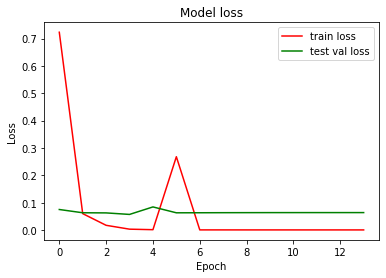

In [81]:
plt.plot(fit.history['loss'], label='train loss', c = 'red')
plt.plot(fit.history['val_loss'], label='test val loss', c = 'green')
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig('chart loss.png')

Function will predict if there is a weapon given in the image path and dimensions

In [82]:
def get_img_prediction(path, model, dim):
    img = get_image_value(path, dim)   
    img = img.reshape(1, img.shape[0], img.shape[1], 3)
    pred = model.predict(img)[0]
    category_dict = {0: 'No Gun', 1: 'Gun'}
    cat_index = np.argmax(pred)
    cat = category_dict[cat_index]
    print(f'Prediction: {cat}\t{int(pred.max()*100)}% Confident')
    img_show = plt.imshow(get_image_value(path, dim))
    return img_show    

Detect the weapon using our weights of incepionV3 model 

In [83]:
dim = (224, 224, 3)   
inc_model = get_inceptionv3(dim)
inc_model.load_weights(r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights.h5') 
predictions = []

Prediction: Gun	99% Confident


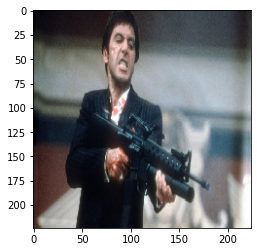

In [84]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/scarface.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: No Gun	93% Confident


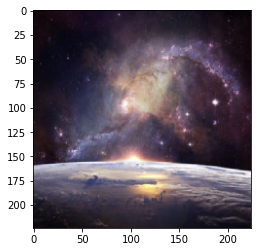

In [85]:

img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/space.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred) 

Prediction: Gun	99% Confident


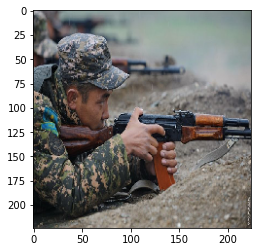

In [86]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/kazakh.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: Gun	98% Confident


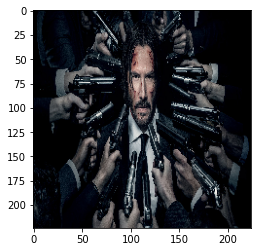

In [87]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/john-wick-chapter-2.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: Gun	99% Confident


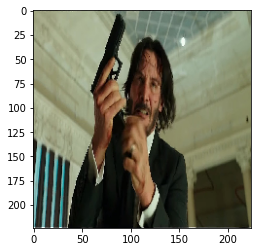

In [88]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/cover3.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: No Gun	99% Confident


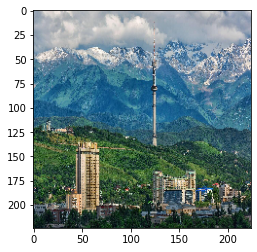

In [89]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/Almaty.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: No Gun	99% Confident


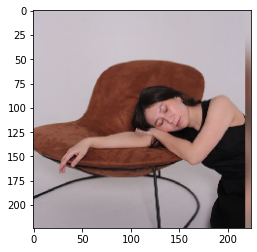

In [90]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/makpal.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

In [91]:
score = model.evaluate(x_test, y_test)

5/5 [==============================] - 0s 80ms/step - loss: 0.0641


In [92]:
score

0.06407008320093155

## VGG16

In [93]:
from tensorflow.keras.applications.vgg16 import VGG16

In [94]:
def get_VGG16(dim):
    model = Sequential()
    base_model = VGG16(weights = 'imagenet', include_top = False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    predictions = Dense(2, activation = 'softmax')(x)
    
    model = Model(inputs = base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy') 
    return model

In [95]:
early_stopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 10, min_delta = 0.00075)
model_checkpoint = ModelCheckpoint(r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights1.h5', verbose = 1, save_best_only = True, monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 50
batch_size = 32
model = get_VGG16(dim = (224,224, 3)) 

In [96]:
fit = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                callbacks = [early_stopping, model_checkpoint, lr_plat],
                validation_data = (x_test, y_test), verbose= 1)

Epoch 1/50
15/15 [==============================] - 3s 168ms/step - loss: 0.4799 - val_loss: 0.2668

Epoch 00001: val_loss improved from inf to 0.26679, saving model to /content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights1.h5
Epoch 2/50
15/15 [==============================] - 2s 157ms/step - loss: 0.2510 - val_loss: 0.1695

Epoch 00002: val_loss improved from 0.26679 to 0.16951, saving model to /content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights1.h5
Epoch 3/50
15/15 [==============================] - 2s 156ms/step - loss: 0.1950 - val_loss: 0.1401

Epoch 00003: val_loss improved from 0.16951 to 0.14012, saving model to /content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights1.h5
Epoch 4/50
15/15 [==============================] - 2s 156ms/step - loss: 0.1237 - val_loss: 0.1250

Epoch 00004: val_loss improved from 0.14012 to 0.12500, saving model to /content/gdrive/My Drive/Co

Plot of model loss

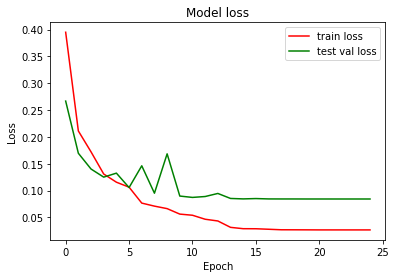

In [97]:
plt.plot(fit.history['loss'], label='train loss', c = 'red')
plt.plot(fit.history['val_loss'], label='test val loss', c = 'green')
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig('chart loss.png')

In [98]:
def get_img_prediction(path, model, dim):
    img = get_image_value(path, dim)   
    img = img.reshape(1, img.shape[0], img.shape[1], 3)
    pred = model.predict(img)[0]
    category_dict = {0: 'No Gun', 1: 'Gun'}
    cat_index = np.argmax(pred)
    cat = category_dict[cat_index]
    print(f'Prediction: {cat}\t{int(pred.max()*100)}% Confident')
    img_show = plt.imshow(get_image_value(path, dim))
    return img_show    

In [99]:
dim = (224, 224, 3)   
inc_model = get_VGG16(dim)
inc_model.load_weights(r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights1.h5') 
predictions = []

Prediction: Gun	99% Confident


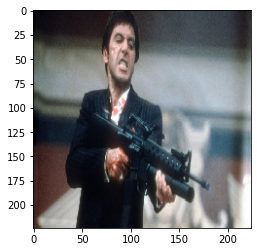

In [100]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/scarface.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: No Gun	97% Confident


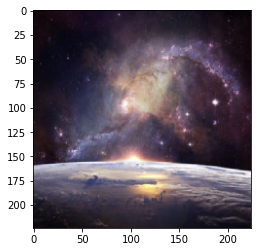

In [101]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/space.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred) 

Prediction: Gun	51% Confident


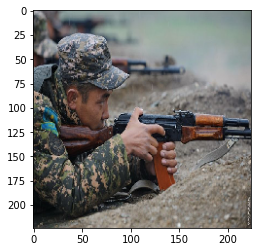

In [102]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/kazakh.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: Gun	98% Confident


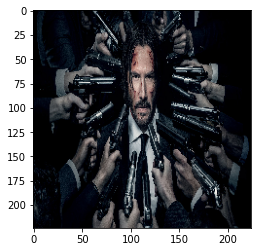

In [103]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/john-wick-chapter-2.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: Gun	99% Confident


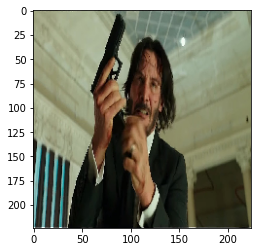

In [104]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/cover3.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: No Gun	98% Confident


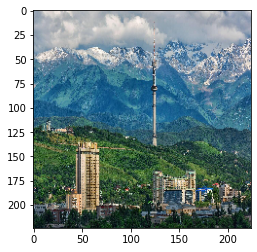

In [105]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/Almaty.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: Gun	99% Confident


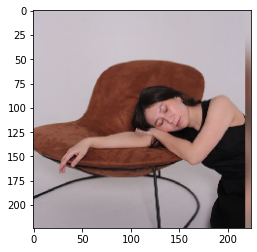

In [106]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/makpal.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

In [107]:
score = model.evaluate(x_test, y_test)

5/5 [==============================] - 1s 122ms/step - loss: 0.0842


In [108]:
score

0.0842263400554657

## Xception

In [109]:
from tensorflow.keras.applications.xception import Xception

In [110]:
def get_Xception(dim):
    model = Sequential()
    base_model = Xception(weights = 'imagenet', include_top = False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    predictions = Dense(2, activation = 'softmax')(x)
    
    model = Model(inputs = base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy') 
    return model

In [111]:
early_stopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 10, min_delta = 0.00075)
model_checkpoint = ModelCheckpoint(r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights2.h5', verbose = 1, save_best_only = True, monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 50
batch_size = 32
model = get_Xception(dim = (224,224, 3)) 

In [112]:
fit = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                callbacks = [early_stopping, model_checkpoint, lr_plat],
                validation_data = (x_test, y_test), verbose= 1)

Epoch 1/50
15/15 [==============================] - 6s 211ms/step - loss: 0.4328 - val_loss: 0.0350

Epoch 00001: val_loss improved from inf to 0.03497, saving model to /content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights2.h5
Epoch 2/50
15/15 [==============================] - 2s 162ms/step - loss: 0.0156 - val_loss: 0.1511

Epoch 00002: val_loss did not improve from 0.03497
Epoch 3/50
15/15 [==============================] - 2s 162ms/step - loss: 0.0197 - val_loss: 0.0267

Epoch 00003: val_loss improved from 0.03497 to 0.02672, saving model to /content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights2.h5
Epoch 4/50
15/15 [==============================] - 2s 164ms/step - loss: 0.0016 - val_loss: 0.0272

Epoch 00004: val_loss did not improve from 0.02672
Epoch 5/50
15/15 [==============================] - 2s 164ms/step - loss: 7.9306e-04 - val_loss: 0.0262

Epoch 00005: val_loss improved from 0.02672 to 0.02623, sav

Plot of model loss

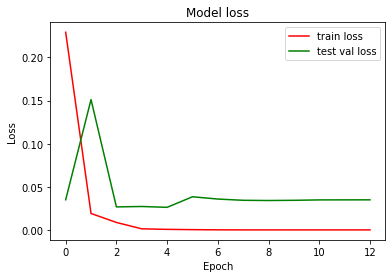

In [113]:
plt.plot(fit.history['loss'], label='train loss', c = 'red')
plt.plot(fit.history['val_loss'], label='test val loss', c = 'green')
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig('chart loss.png')

In [114]:
def get_img_prediction(path, model, dim):
    img = get_image_value(path, dim)   
    img = img.reshape(1, img.shape[0], img.shape[1], 3)
    pred = model.predict(img)[0]
    category_dict = {0: 'No Gun', 1: 'Gun'}
    cat_index = np.argmax(pred)
    cat = category_dict[cat_index]
    print(f'Prediction: {cat}\t{int(pred.max()*100)}% Confident')
    img_show = plt.imshow(get_image_value(path, dim))
    return img_show    

In [115]:
dim = (224, 224, 3)   
inc_model = get_Xception(dim)
inc_model.load_weights(r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/ModelWeights2.h5') 
predictions = []

Prediction: Gun	99% Confident


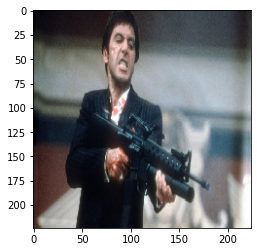

In [116]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/scarface.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: No Gun	99% Confident


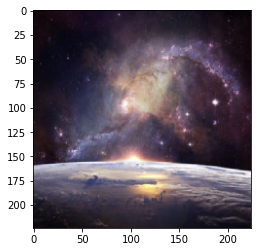

In [117]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/space.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred) 

Prediction: Gun	99% Confident


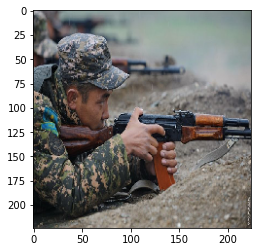

In [118]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/kazakh.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: Gun	99% Confident


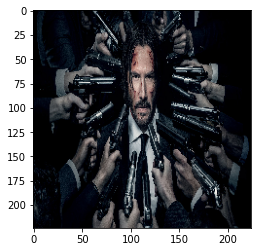

In [119]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/john-wick-chapter-2.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: Gun	99% Confident


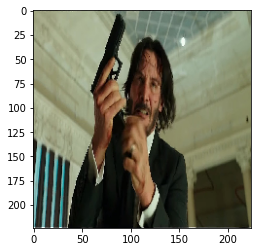

In [120]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/cover3.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: No Gun	99% Confident


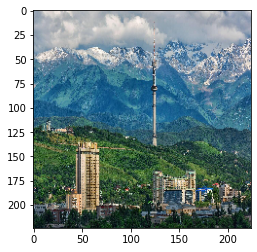

In [121]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/Almaty.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: No Gun	88% Confident


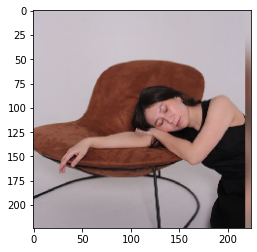

In [122]:
img_path = r'/content/gdrive/My Drive/Colab Notebooks/CV/3/Guns_Detection_InceptionV3-main/test/makpal.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

In [123]:
score = model.evaluate(x_test, y_test)

5/5 [==============================] - 1s 123ms/step - loss: 0.0349


In [124]:
score

0.03491645306348801